# Tutorial 2.1: One-Body Potential Energy Surface

In this section, we construct, from scratch, a 1-body MB-nrg-style PEF for CH3-NH2.

## 2.1.0 Definitions and Imports

In [72]:
%load_ext autoreload
%autoreload 2
%matplotlib agg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
%run Tutorial_2_Imports.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
%run Tutorial_2_Paths.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2.x.y Normal Modes Configuration Generation

Now, we will generate the first batch of configurations for our training set. This batch will come from randomly sampling the vibrational normal modes of methylamine.

First, we need to calculate the vibrational modes of the optimized geometry:

In [75]:
definition_CH3NH2 = read_definition(paths.definitions.systems.CH3NH2)
minimized_structure_CH3NH2, minimized_energy_CH3NH2 = read_system_and_energy(definition_CH3NH2, paths.structures.minimized_CH3NH2)
vibrational_modes_CH3NH2 = read_vibrational_modes(paths.structures.vibrational_modes_CH3NH2)

In [76]:
configuration_generator = NormalModesConfigurationGenerator(
        minimized_structure_CH3NH2,
        vibrational_modes_CH3NH2,
)

configurations_vibrational_modes_CH3NH2 = list(configuration_generator.generate_configurations(num_configs=1000, seed=54321))
write_systems(paths.PIP_CH3NH2.configs.vibrational_modes, configurations_vibrational_modes_CH3NH2)

Will generate configurations over a piecewise temperature distribution.
Temp Distribution: temp (au) = x < 0.05 : 0.00018608984445301583 | x < 0.45 : 0.0009304492222650791 | x < 0.75 : 0.0018608984445301583 | x < 0.95 : 0.0037217968890603166 | otherwise : 0.009304492222650791 for x in range [0,1].
Beginning normal modes configuration generation.
Will generate 1000 configs over the temperature distribution.
Generating Temperature Distribution Configs...
Normal Distribution Configuration generation complete! Generated 1000 configs.


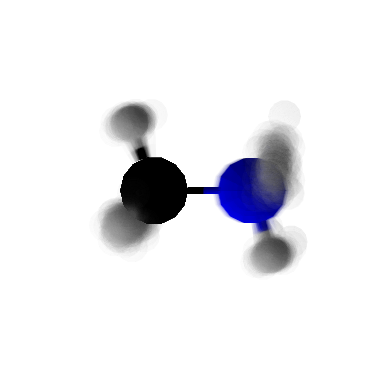

In [77]:
render_overlayed_systems(
    configurations_vibrational_modes_CH3NH2,
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[4].point, system.atoms[3].point),
    alpha=0.02,
    num_to_show=100
)

Note: the seed here determines which configurations get generated. The same seed will always produce the same configurations. In a later step, we "cheat" and have pre-performed the CCSD(T) calculations for these structures, so please don't change the seed, because then the energies we give you wont match the structures that get generated!

## II.1.? Parallel-Bias Metadynamics Configuration Generation

Let's generate the second set of configurations for our training set, those from metadynamics configurations.

In [78]:
bond_params, angle_params, nonbonded_params = get_pbmetad_parameters(
        minimized_structure_CH3NH2
)

In [79]:
bond_params

{('A', 'B'): (60, 1.0903433951923782),
 ('A', 'C'): (100, 1.4856129653501475),
 ('C', 'D'): (60, 1.033467459772488)}

In [80]:
angle_params

{('B', 'A', 'B'): (15, 108.22780539695198),
 ('A', 'C', 'D'): (15, 107.31783462990296),
 ('B', 'A', 'C'): (15, 110.67220063179694),
 ('D', 'C', 'D'): (15, 104.37928092066464)}

In [81]:
nonbonded_params

{'A': (0.03, 1.8), 'B': (0.01, 0.9), 'C': (0.03, 1.8), 'D': (0.01, 0.9)}

In [82]:
charges = read_parameters(paths.Vphys.charges)
charges = {symmetry: charges[symmetry]*1/3 for symmetry in charges}

In [83]:
charges

{'A': 0.08756246606704443,
 'B': -0.007865097851811933,
 'C': -0.22027848714757195,
 'D': 0.07815565731798167}

In [84]:
paths.scratch.pbmetad_CH3NH2.remove()
paths.restart.pbmetad_CH3NH2.remove()

In [85]:
perform_pbmetad_simulation(
        lammps_executable_path,
        [minimized_structure_CH3NH2],
        num_configs=500000,
        sample_interval=10,
        temperature=700,
        seed=12345,
        configurations_path=paths.PIP_CH3NH2.configs.pbmetad_pool,
        bond_params=bond_params,
        angle_params=angle_params,
        nonbonded_params=nonbonded_params,
        charges=charges,
        pbmetad_workdir=paths.scratch.pbmetad_CH3NH2,
        restart_path=paths.restart.pbmetad_CH3NH2
)

Preparing PBMetaD Simulation...
Running PBMetaD Simulation...
Converting PBMetaD trajectory to XYZ...


In [86]:
split_pool(
        definition_CH3NH2,
        paths.PIP_CH3NH2.configs.pbmetad_pool,
        pool_size=500000,
        num_configs_to_split=200,
        unsplit_path=paths.PIP_CH3NH2.configs.pbmetad_train_pool,
        split_path=paths.PIP_CH3NH2.configs.pbmetad_test,
        strategy="INTERVAL",
)

In [87]:
paths.scratch.fps_CH3NH2.remove()
paths.restart.fps_CH3NH2.remove()

In [88]:
pbmetad_configs_CH3NH2 = perform_fps(
        definition_CH3NH2,
        minimized_structure_CH3NH2,
        vibrational_modes_CH3NH2,
        paths.PIP_CH3NH2.configs.pbmetad_train_pool,
        num_pool_configs=500000-200,
        num_phase1_input_configs=100000,
        approx_configs_to_select=1000,
        fps_workdir=paths.scratch.fps_CH3NH2,
        restart_path=paths.restart.fps_CH3NH2,
        num_threads=16
)

Number of permutations: 12
Beginning featurization...
Featurization progress: |====================================================================================================| - 100000/100000
Featurized 100000 configurations.
Initializing round 1 FPS...
BallTree built!
Performing round 1 FPS...
Round 1 FPS iterations: |====================================================================================================| - 1000/1000
Completed round 1 fps, selected 1000 configs, max distance: 0.8320923849592116
Number of permutations: 12
Beginning featurization...
Featurization progress: |====================================================================================================| - 399800/399800
Featurized 399800 configurations.
Initializing round 2 FPS...
BallTree built!
Performing round 2 FPS...
Round 2 FPS iterations: 557
Completed round 2 fps, selected 557 configs.
Selected 1557 total configs by FPS.


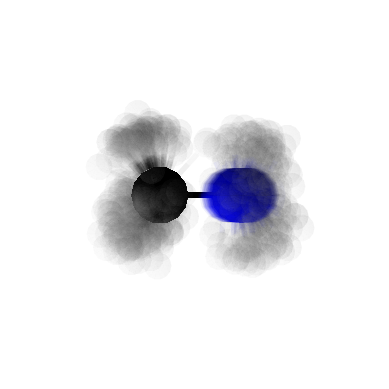

In [89]:
render_overlayed_systems(
    pbmetad_configs_CH3NH2,
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[4].point, system.atoms[3].point),
    alpha=0.03,
    num_to_show=100
)

In [90]:
write_systems(paths.PIP_CH3NH2.configs.pbmetad_train, pbmetad_configs_CH3NH2)

## II.1.? Energy Calculation

Next, we need to perform the electronic structure calculations with our chosen reference level of theory. We will use CCSD(T). Because this can be quite expensive and this tutorial is menat to be something that can be finished in a few hours, we have precomputed the energies for you. So we will just copy them over:

In [91]:
calculator = Psi4Calculator("HF", "STO-3G", paths.logs)

In [92]:
paths.restart.energies_pbmetad_configs_CH3NH2.remove()

In [93]:
energies_vibrational_modes_CH3NH2 = calculate_nmer_energies(
        configurations_vibrational_modes_CH3NH2,
        calculator,
        get_qchem_job_manager(paths.jobs),
        paths.restart.energies_vibrational_mode_configs_CH3NH2,
        num_threads=4,
        mem_mb=4000
)
write_systems_and_nmer_energies(paths.PIP_CH3NH2.configs.vibrational_modes_energies, (configurations_vibrational_modes_CH3NH2, energies_vibrational_modes_CH3NH2))

Running energy calculations |====================================================================================================| - 1000/1000
Completed n-mer energy calculations!


In [ ]:
energies_pbmetad_CH3NH2 = calculate_nmer_energies(
        pbmetad_configs_CH3NH2,
        calculator,
        get_qchem_job_manager(paths.jobs),
        paths.restart.energies_pbmetad_configs_CH3NH2,
        num_threads=4,
        mem_mb=4000
)
write_systems_and_nmer_energies(paths.PIP_CH3NH2.configs.pbmetad_train_energies, (pbmetad_configs_CH3NH2, energies_pbmetad_CH3NH2))

In [ ]:
energies_1b_vibrational_modes_CH3NH2 = calculate_many_body_energies(
    configurations_vibrational_modes_CH3NH2,
    energies_vibrational_modes_CH3NH2,
    minimized_monomer_energies=[minimized_energy_CH3NH2]
)

energies_1b_pbmetad_CH3NH2 = calculate_many_body_energies(
    pbmetad_configs_CH3NH2,
    energies_pbmetad_CH3NH2,
    minimized_monomer_energies=[minimized_energy_CH3NH2]
)

In [ ]:
write_training_set_file(
        paths.PIP_CH3NH2.training_set,
        (
                [*configurations_vibrational_modes_CH3NH2, *pbmetad_configs_CH3NH2],
                [*energies_1b_vibrational_modes_CH3NH2, *energies_1b_pbmetad_CH3NH2],
                [*energies_1b_vibrational_modes_CH3NH2, *energies_1b_pbmetad_CH3NH2],
        )
)

In [ ]:
min(energies_1b_vibrational_modes_CH3NH2), max(energies_1b_vibrational_modes_CH3NH2)

In [ ]:
min(energies_1b_pbmetad_CH3NH2), max(energies_1b_pbmetad_CH3NH2)

## II.1.? Polynomial Generation

In [65]:
pip_1b_max_order = 3

In [66]:
generate_polynomial(
        definition_CH3NH2,
        max_degree=pip_1b_max_order,
        polynomial_info_path=paths.PIP_CH3NH2.PIP.info,
        polynomial_dir=paths.PIP_CH3NH2.PIP.polynomial,
        filters=[]
)

(A1B3C1D2)
Generating polynomial input file for symmetry (A1B3C1D2) into file Tutorial_2_workdir/PIP_CH3NH2/PIP/info.in.
Successfully generated polynomial input file! 21 total variables.
File Tutorial_2_workdir/PIP_CH3NH2/PIP/polynomial/poly.log already exists, moving existing Tutorial_2_workdir/PIP_CH3NH2/PIP/polynomial/poly.log to Tutorial_2_workdir/PIP_CH3NH2/PIP/polynomial/poly.log.backup-2 to make way for new file.
Generating terms up to degree 3...
Generating polynomial: |====================================================================================================| - 63/63
8 possible degree 1 terms, now filtering them...
There were 8 accepted degree 1 terms.
53 possible degree 2 terms, now filtering them...
There were 53 accepted degree 2 terms.
292 possible degree 3 terms, now filtering them...
There were 292 accepted degree 3 terms.
There were 353 accepted terms over all
Writing Gradients C++: |=============================================================================

## II.1.? Polynomial Parametrization

In [67]:
polarizabilities = read_parameters(paths.Vphys.polarizabilities)
polarizability_factors = read_parameters(paths.Vphys.polarizability_factors)
charges = read_parameters(paths.Vphys.charges)
C6 = read_parameters(paths.Vphys.C6)
d6 = read_parameters(paths.Vphys.d6)

In [68]:
print("polarizabilities:", polarizabilities)
print("polarizability_factors:", polarizability_factors)
print("charges:", charges)
print("C6:", C6)
print("d6:", d6)

polarizabilities: {'A': 1.1961690533033624, 'B': 0.3322263799649547, 'C': 0.9504508010167653, 'D': 0.3532759027887244, 'E': 1.31, 'F': 0.294}
polarizability_factors: {'A': 1.1961690533033624, 'B': 0.3322263799649547, 'C': 0.9504508010167653, 'D': 0.3532759027887244, 'E': 1.31, 'F': 0.294}
charges: {'A': 0.2626873982011333, 'B': -0.023595293555435798, 'C': -0.6608354614427159, 'D': 0.234466971953945}
C6: {('A', 'E'): 215.65978868741462, ('A', 'F'): 103.08292627758921, ('B', 'E'): 81.55966323179395, ('B', 'F'): 37.424572619961545, ('C', 'E'): 200.9159401221131, ('C', 'F'): 92.4521980830751, ('D', 'E'): 82.35886249981964, ('D', 'F'): 38.01708242211851, ('E', 'E'): 237.3212214147944, ('E', 'F'): 83.49556669872743, ('F', 'F'): 20.09358600184719}
d6: {('A', 'E'): 3.47137451171875, ('A', 'F'): 4.19769287109375, ('B', 'E'): 4.4586181640625, ('B', 'F'): 5.7342529296875, ('C', 'E'): 3.5552978515625, ('C', 'F'): 4.3212890625, ('D', 'E'): 4.43267822265625, ('D', 'F'): 5.69000244140625, ('E', 'E'):

In [69]:
generate_pip_parametizer(
        definition_CH3NH2,
        max_degree=4,
        polynomial_info_path=paths.PIP_CH3NH2.PIP.info,
        polynomial_dir=paths.PIP_CH3NH2.PIP.polynomial,
        parametizer_dir=paths.PIP_CH3NH2.PIP.parameterizer,
        workdir=paths.scratch.PIP_CH3NH2,
        symmetry_to_charge=charges,
        symmetry_to_polarizability=polarizabilities,
        symmetry_to_polarizability_factor=polarizability_factors,
        symmetries_to_C6=C6,
        symmetries_to_d6=d6,
        monomer_names=["ch3nh2"],
        is_mbpol=[False]
)

File Tutorial_2_workdir/scratch/PIP_CH3NH2/config.ini already exists, moving existing Tutorial_2_workdir/scratch/PIP_CH3NH2/config.ini to Tutorial_2_workdir/scratch/PIP_CH3NH2/config.ini.backup-25 to make way for new file.
Completed generating config file Tutorial_2_workdir/scratch/PIP_CH3NH2/config.ini.
File Tutorial_2_workdir/scratch/PIP_CH3NH2/config.ini already exists, moving existing Tutorial_2_workdir/scratch/PIP_CH3NH2/config.ini to Tutorial_2_workdir/scratch/PIP_CH3NH2/config.ini.backup-26 to make way for new file.
Executing python generator script
Generating fitcode for molecule with symmetry A1B3C1D2...
Using mbpol for 0 fragments.
0 fragments have lone pairs.
Using exp variables for intramolecular interactions.
Using exp variables for intermolecular interactions.
Using coul variables for lone pair interactions.
353 terms in the polynomial.
Atoms in the molecule: A1 B1 B2 B3 C1 D1 D2.
21 variables in the polynomial.
8 non-linear parameters in the polynomial.


mv: cannot stat ‘mbnrg_1b_A1B3C1D2_deg3_v1.0.h’: No such file or directory
mv: cannot stat ‘mbnrg_1b_A1B3C1D2_deg3_v1.0.cpp’: No such file or directory
mv: cannot stat ‘poly_1b_A1B3C1D2_deg3_v1.0.h’: No such file or directory
mv: cannot stat ‘poly_1b_A1B3C1D2_deg3_grad_v1.0.cpp’: No such file or directory
mv: cannot stat ‘poly_1b_A1B3C1D2_deg3_nograd_v1.0.cpp’: No such file or directory


Compiling Parametrizer...
Compiled!


In [71]:
parametrize_pip(
        definition_CH3NH2,
        parametizer_dir=paths.PIP_CH3NH2.PIP.parameterizer,
        parametrization_dir=paths.PIP_CH3NH2.PIP.parametrization,
        training_set_path=paths.PIP_CH3NH2.training_set,
        workdir=paths.scratch.fitting_CH3NH2,
        monomer_names=["ch3nh2"],
        is_mbpol=[False],
        num_fits_to_run=10,
        num_threads=16,
        DE=10,
        alpha=0.0005
)

fit1 folder already exists. Trying next index.
fit2 folder already exists. Trying next index.
fit3 folder already exists. Trying next index.
fit4 folder already exists. Trying next index.
fit5 folder already exists. Trying next index.
fit6 folder already exists. Trying next index.
fit7 folder already exists. Trying next index.
fit8 folder already exists. Trying next index.
fit9 folder already exists. Trying next index.
fit10 folder already exists. Trying next index.
Succesfully created fit folder fit11.
Succesfully created fit folder fit12.
Succesfully created fit folder fit13.
Succesfully created fit folder fit14.
Succesfully created fit folder fit15.
Succesfully created fit folder fit16.
Succesfully created fit folder fit17.
Succesfully created fit folder fit18.
Succesfully created fit folder fit19.
Succesfully created fit folder fit20.
fit5 is already done. Continuing...
fit10 is already done. Continuing...
fit17 is running.

fit17 is completed.
fit2 is already done. Continuing...
f

## II.1.? Implementation in MBX

## II.1.? Test MBX Implementation

## II.1.? Run a Gas-Phase Monomer Simulation

In [57]:
import os
os.getcwd()

'/home/ebullvul/projects/QDMS_2025/QDMS_2025/tutorials/2_Many-Body_Model_Build-Along'